<a href="https://colab.research.google.com/github/jinhongZhu/STAT542FinalCode/blob/main/542_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier


In [67]:
#Mount Google Drive and load data
from google.colab import drive
drive.mount('/content/drive')
import os
os.listdir("/content/drive/MyDrive")
df = pd.read_csv("/content/drive/MyDrive/covtype.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [68]:
#Feature/label split + stratified sampling + train/test split


# Split features and target
X = df.drop(columns=["Cover_Type"])
# shift labels from 1–7 to 0–6
y = df["Cover_Type"] - 1

# Stratified random sampling: keep 100,000 rows, preserve class proportions
X_sample, _, y_sample, _ = train_test_split(
    X, y,
    train_size=100000,
    stratify=y,
    random_state=42
)

print("Sampled class distribution:")
print(y_sample.value_counts())

# Train/Test split on the sampled data
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample,
    test_size=0.2,
    random_state=42,
    stratify=y_sample
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Sampled class distribution:
Cover_Type
1    48760
0    36460
2     6154
6     3530
5     2989
4     1634
3      473
Name: count, dtype: int64
Train shape: (80000, 54)
Test shape: (20000, 54)


In [69]:
y_sample.value_counts()

,count
Cover_Type,
1,48760
0,36460
2,6154
6,3530
5,2989
4,1634
3,473


In [70]:
# Standardize continuous (non-binary) features
# Continuous columns = all columns except Wilderness* and Soil_Type*
continuous_cols = [
    col for col in X.columns
    if not col.startswith("Wilderness") and not col.startswith("Soil")
]

scaler = StandardScaler()
X_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])


Random Forest (unbalanced)
Accuracy: 0.85945
Macro Precision: 0.883061027632479
Macro Recall: 0.7209556454678607

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      7292
           1       0.84      0.92      0.88      9752
           2       0.85      0.90      0.87      1231
           3       0.82      0.70      0.76        94
           4       0.98      0.26      0.41       327
           5       0.88      0.62      0.73       598
           6       0.93      0.82      0.87       706

    accuracy                           0.86     20000
   macro avg       0.88      0.72      0.77     20000
weighted avg       0.86      0.86      0.86     20000



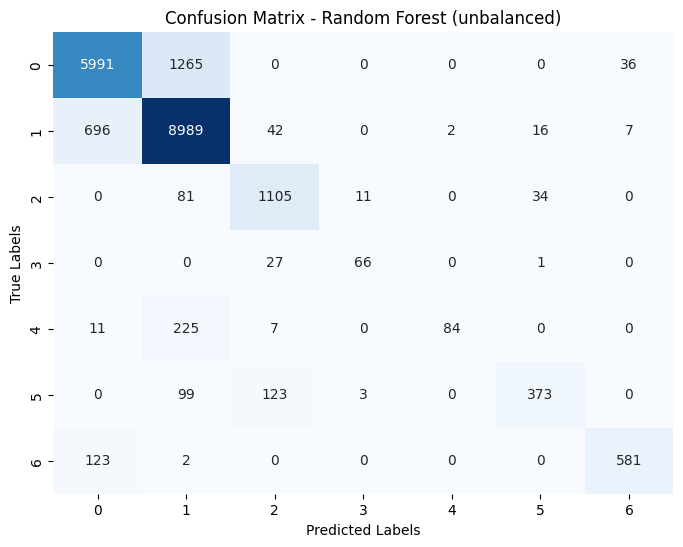

In [72]:
# Train baseline Random Forest (unbalanced) and evaluate

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Basic metrics
print("\nRandom Forest (unbalanced)")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Macro Precision:", precision_score(y_test, y_pred_rf, average='macro'))
print("Macro Recall:", recall_score(y_test, y_pred_rf, average='macro'))

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix (unbalanced RF)
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Random Forest (unbalanced)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Random Forest (class_weight='balanced')
Unbalanced RF Accuracy: 0.85945
Balanced RF Accuracy: 0.9083

Balanced RF Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      7292
           1       0.90      0.95      0.92      9752
           2       0.87      0.92      0.89      1231
           3       0.81      0.73      0.77        94
           4       0.94      0.50      0.65       327
           5       0.88      0.72      0.79       598
           6       0.93      0.88      0.91       706

    accuracy                           0.91     20000
   macro avg       0.89      0.80      0.84     20000
weighted avg       0.91      0.91      0.91     20000



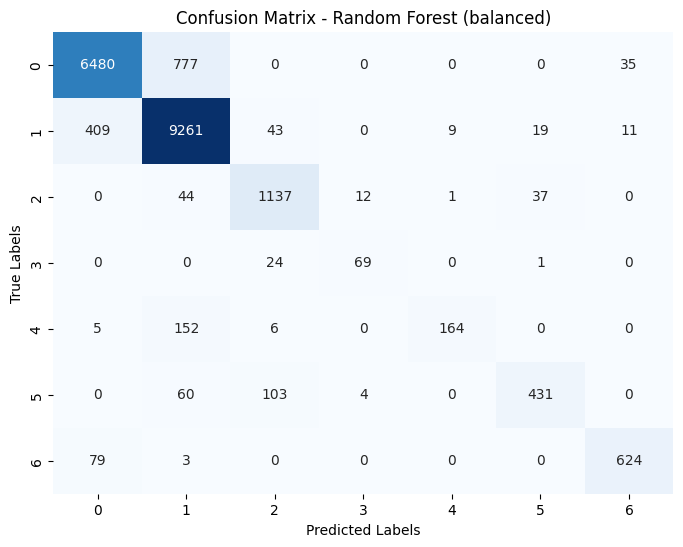

In [73]:
# Train class-weight balanced Random Forest and evaluate

rf_balanced = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_balanced.fit(X_train, y_train)
y_pred_bal = rf_balanced.predict(X_test)

print("\nRandom Forest (class_weight='balanced')")
print("Unbalanced RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Balanced RF Accuracy:", accuracy_score(y_test, y_pred_bal))

print("\nBalanced RF Classification Report:")
print(classification_report(y_test, y_pred_bal))

# Confusion matrix (balanced RF)
cm_bal = confusion_matrix(y_test, y_pred_bal)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Random Forest (balanced)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [74]:
# 10-fold CV for BOTH unbalanced and balanced RF

from sklearn.model_selection import StratifiedKFold, cross_val_score
import pandas as pd
import numpy as np

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# ----- Unbalanced RF -----
scores_unbalanced = cross_val_score(
    rf_clf,
    X_sample,
    y_sample,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# ----- Balanced RF -----
scores_balanced = cross_val_score(
    rf_balanced,
    X_sample,
    y_sample,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

print("Unbalanced RF CV Accuracies:", scores_unbalanced)
print("Balanced RF CV Accuracies:", scores_balanced)

# -------- Create comparison table --------
cv_results = pd.DataFrame({
    "Fold": np.arange(1, 11),
    "Unbalanced_RF": scores_unbalanced,
    "Balanced_RF": scores_balanced
})

cv_results["Difference"] = cv_results["Balanced_RF"] - cv_results["Unbalanced_RF"]

print("\n===== 10-Fold CV Comparison Table =====")
print(cv_results)

print("\n===== Summary =====")
print("Unbalanced RF Mean:", scores_unbalanced.mean())
print("Balanced RF Mean:", scores_balanced.mean())
print("Difference:", scores_balanced.mean() - scores_unbalanced.mean())

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Unbalanced RF CV Accuracies: [0.8611 0.8597 0.8517 0.8593 0.8541 0.8578 0.8571 0.8592 0.8589 0.8541]
Balanced RF CV Accuracies: [0.9145 0.913  0.906  0.913  0.9097 0.9088 0.9109 0.913  0.9076 0.9091]

===== 10-Fold CV Comparison Table =====
   Fold  Unbalanced_RF  Balanced_RF  Difference
0     1         0.8611       0.9145      0.0534
1     2         0.8597       0.9130      0.0533
2     3         0.8517       0.9060      0.0543
3     4         0.8593       0.9130      0.0537
4     5         0.8541       0.9097      0.0556
5     6         0.8578       0.9088      0.0510
6     7         0.8571       0.9109      0.0538
7     8         0.8592       0.9130      0.0538
8     9         0.8589       0.9076      0.0487
9    10         0.8541       0.9091      0.0550

===== Summary =====
Unbalanced RF Mean: 0.8573000000000001
Balanced RF Mean: 0.91056
Difference: 0.053259999999999974


                               feature  importance
0                            Elevation    0.283269
5      Horizontal_Distance_To_Roadways    0.092242
9   Horizontal_Distance_To_Fire_Points    0.081665
3     Horizontal_Distance_To_Hydrology    0.047334
13                    Wilderness_Area4    0.046513
4       Vertical_Distance_To_Hydrology    0.043894
1                               Aspect    0.039961
7                       Hillshade_Noon    0.038860
6                        Hillshade_9am    0.034932
8                        Hillshade_3pm    0.034498


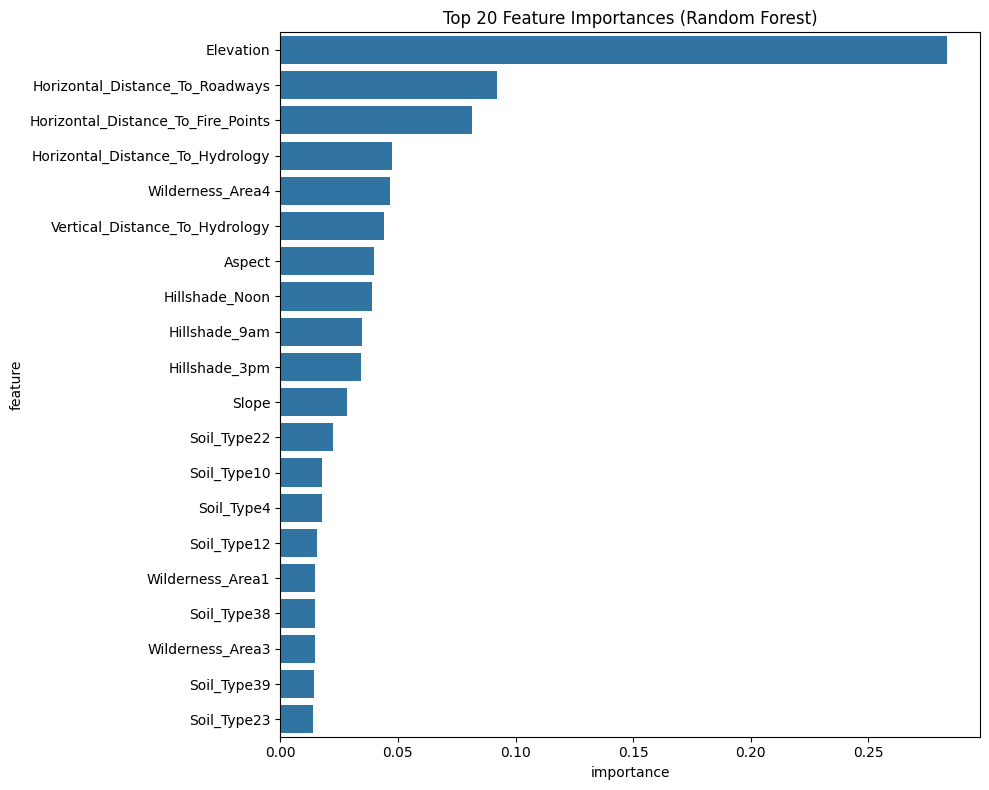

In [75]:
# Feature importance (unbalanced)

importances = rf_clf.feature_importances_
feat_names = X.columns

fi_df = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print(fi_df.head(10))

plt.figure(figsize=(10, 8))
sns.barplot(data=fi_df.head(20), x="importance", y="feature")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

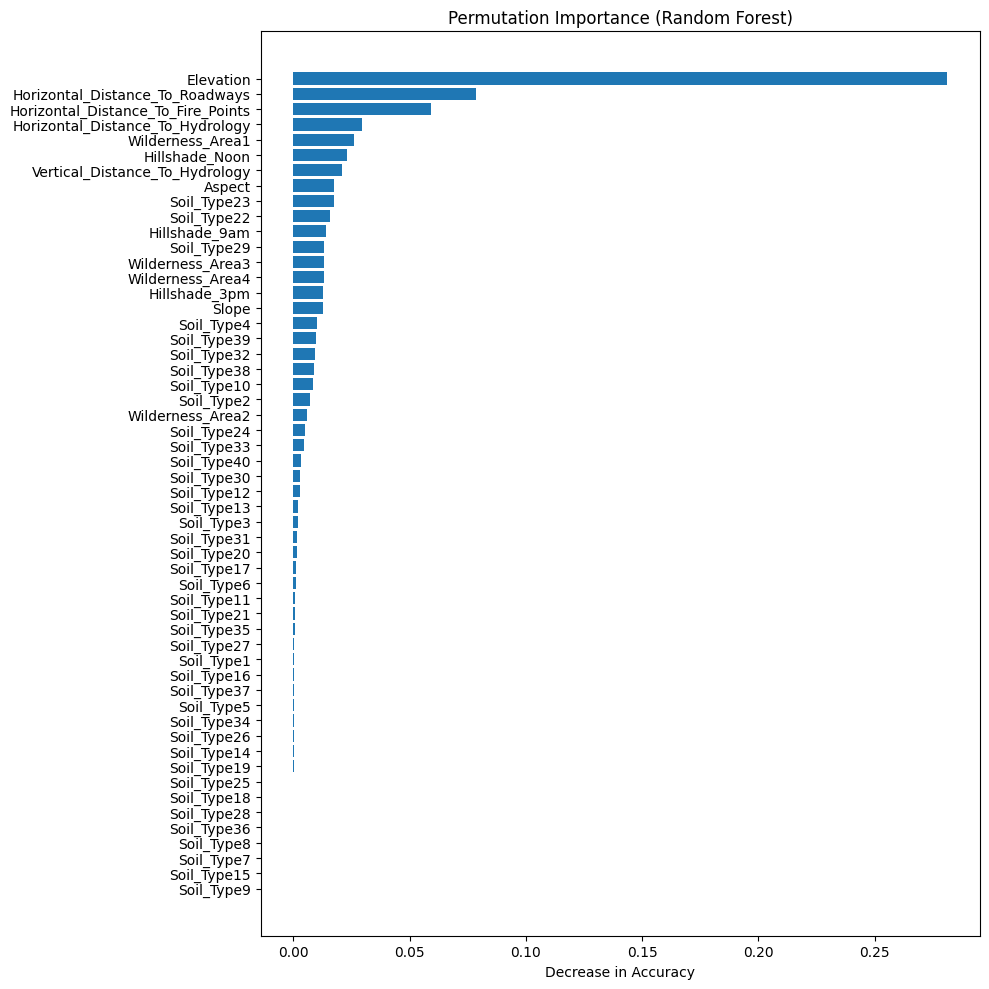

In [76]:
#Permutation importance (unbalanced)

from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_clf,
    X_test,
    y_test,
    n_repeats=3,
    random_state=42
)

perm_sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 10))
plt.barh(
    np.array(X_train.columns)[perm_sorted_idx],
    result.importances_mean[perm_sorted_idx]
)
plt.title("Permutation Importance (Random Forest)")
plt.xlabel("Decrease in Accuracy")
plt.tight_layout()
plt.show()

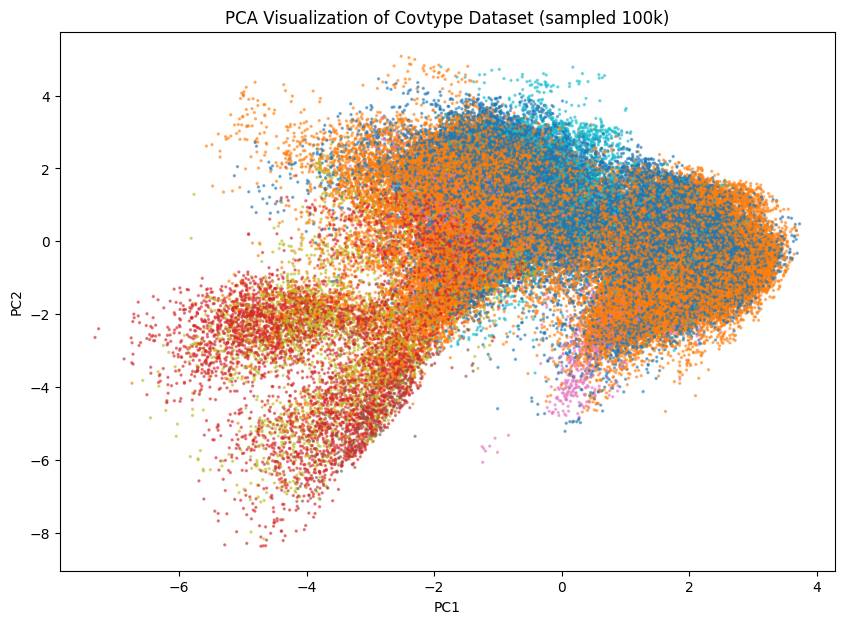

Top 10 features contributing to PC1:
Wilderness_Area1                      0.426071
Horizontal_Distance_To_Roadways       0.304280
Wilderness_Area3                      0.294013
Horizontal_Distance_To_Fire_Points    0.284864
Slope                                 0.275960
Wilderness_Area4                      0.271260
Soil_Type29                           0.255169
Elevation                             0.240885
Hillshade_9am                         0.230285
Soil_Type10                           0.228805
Name: PC1, dtype: float64

Top 10 features contributing to PC2:
Elevation                           0.373871
Hillshade_3pm                       0.370072
Hillshade_Noon                      0.333624
Wilderness_Area4                    0.299774
Aspect                              0.275379
Wilderness_Area3                    0.270882
Horizontal_Distance_To_Hydrology    0.213341
Hillshade_9am                       0.199079
Soil_Type32                         0.194623
Soil_Type10             

In [77]:
# PCA visualization and PC loadings

from sklearn.decomposition import PCA

# Re-scale X_sample for PCA (all features)
scaler_pca = StandardScaler()
X_sample_scaled = scaler_pca.fit_transform(X_sample)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_sample, cmap='tab10', s=2, alpha=0.5)
plt.title("PCA Visualization of Covtype Dataset (sampled 100k)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# PC loadings (which features contribute most to PC1/PC2)
pc_loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=X_sample.columns
)

print("Top 10 features contributing to PC1:")
print(pc_loadings['PC1'].abs().sort_values(ascending=False).head(10))

print("\nTop 10 features contributing to PC2:")
print(pc_loadings['PC2'].abs().sort_values(ascending=False).head(10))